In [1]:
from outlaw.nb_util import setup_nb
setup_nb()

In [2]:
from pprint import pprint
import outlaw.inla as inla
import outlaw.quad as quad
import outlaw.berry as berry
import numpy as np
from numpy import nan
import matplotlib.pyplot as plt
import scipy.stats
import jax
import jax.numpy as jnp
import numpyro.infer
import numpyro.distributions as dist

/Users/tbent/.mambaforge/envs/confirm/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
N = 100
data = berry.figure2_data(N=N)

In [4]:
sig2_rule = quad.log_gauss_rule(15, 1e-6, 1e3)
ops = berry.optimized(sig2_rule.pts)
p_ex = dict(sig2=np.array([nan]), theta=np.zeros(4))
lj_f = berry.log_joint(4)
ops = inla.from_log_joint(lj_f, p_ex)
p_pinned = dict(sig2=sig2_rule.pts, theta=None)
logpost, x_max, hess_info, iters = jax.vmap(
    ops.laplace_logpost, in_axes=(None, None, 0)
)(jnp.zeros((15, 4)), p_pinned, data)
sig2_post = inla.exp_and_normalize(logpost, sig2_rule.wts[None], axis=1)

In [5]:
invv = jax.jit(jax.vmap(jax.vmap(ops.invert)))
inv_hess = invv(hess_info)
appx_gaussian_cov = -inv_hess[0,:]
std_dev = np.sqrt(np.diagonal(appx_gaussian_cov, axis1=-2, axis2=-1))

## Set up the full laplace appx

We normally call the conditional laplace function with an array of $\sigma^2$ values, but we want to be able to differentiate the scalar version of this function. So, we write a scalar wrapper:

In [6]:
def cond_laplace_logpost_scalar(cx, x_max, inv_hess_row, sig2, data, arm_idx):
    return ops.cond_laplace_logpost(
        x_max[None],
        inv_hess_row[None],
        dict(sig2=sig2[None], theta=None),
        data,
        cx[None],
        arm_idx,
        True,
    )[0]

And then we check that the scalar version is doing what we expect. Compare the full Laplace calculation against the Gaussian calculation just as a sanity check on whether everything is working well.

In [7]:
arm_logpost_f = jax.jit(
    jax.vmap(
        jax.vmap(
            jax.vmap(
                cond_laplace_logpost_scalar, in_axes=(0, 0, 0, 0, None, None)
            ), in_axes=(0, 0, 0, None, 0, None)
        ),
        in_axes=(0, None, None, None, None, None),
    ),
    static_argnums=(5,),
)
arm_post = []
arm_cx = []
for arm_idx in range(4):
    # NOTE: dividing inv_hess by 4 so that grid is denser around the mode
    cx, wts = inla.gauss_hermite_grid(
        x_max, inv_hess[..., arm_idx, :] / 3, arm_idx, n=51
    )
    arm_logpost = arm_logpost_f(
        cx, x_max, inv_hess[:, :, arm_idx], p_pinned['sig2'], data, arm_idx
    )
    arm_cx.append(cx)
    arm_post.append(inla.exp_and_normalize(arm_logpost, wts, axis=0))
arm_cx = jnp.array(arm_cx)
arm_post = jnp.array(arm_post)

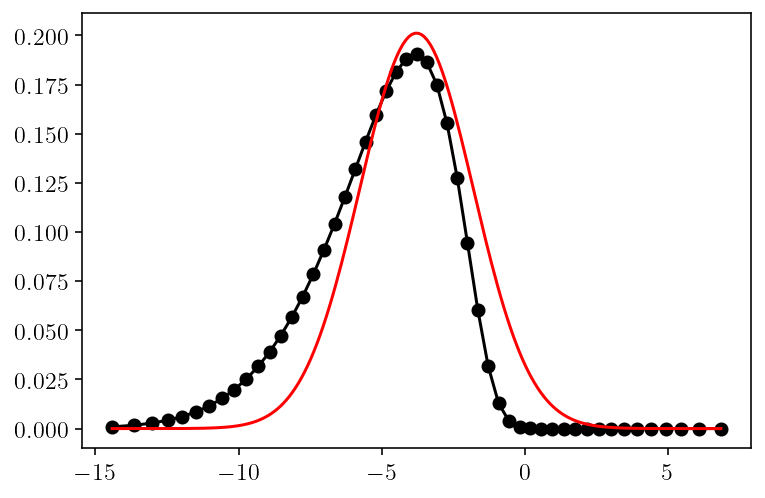

In [8]:
armi_idx = 0
sig_idx = 10
Asd = std_dev[sig_idx, armi_idx]
Amu = x_max[0, sig_idx, armi_idx]
arm_xs = arm_cx[armi_idx,:,0,sig_idx]
xs = np.linspace(np.min(arm_xs), np.max(arm_xs), 200)
plt.plot(arm_xs, arm_post[armi_idx,:,0,sig_idx], 'k-o')
plt.plot(xs, scipy.stats.norm.pdf(xs, loc=Amu, scale=Asd), 'r-')
plt.show()

## Compute a Taylor expansion.

Currently, done with automatic differentiation, but it should be done analytically in the future.

In [9]:
def derivative(order):
    f = cond_laplace_logpost_scalar
    for i in range(order):
        f = jax.grad(f)
    return jax.jit(
        jax.vmap(
            jax.vmap(
                jax.vmap(
                    f, in_axes=(0, 0, 0, 0, None, None)
                ), in_axes=(0, 0, 0, None, 0, None)
            ),
            in_axes=(0, None, None, None, None, None),
        ),
        static_argnums=(5,),
    )

d_fs = [derivative(d) for d in [0, 1,2,3,4]]

In [10]:
arm_idx = 0
cx, wts = inla.gauss_hermite_grid(
    x_max, inv_hess[..., arm_idx, :], arm_idx, n=25
)
ds = []
for i in range(5):
    ds.append(d_fs[i](
        x_max[None, ..., arm_idx], x_max, inv_hess[:, :, arm_idx], p_pinned['sig2'], data, arm_idx
    )[0])
ds = np.array(ds)
ds.shape, ds[:, 0, -4]

((5, 100, 15),
 array([-3.13562366e+01, -1.99520573e-03, -6.96614613e-02, -5.57822794e-02, -5.51537242e-02]))

Let's plot the comparison of the taylor expansion against the true full Laplace calculation. This confirms that the expansion is doing what we expect.

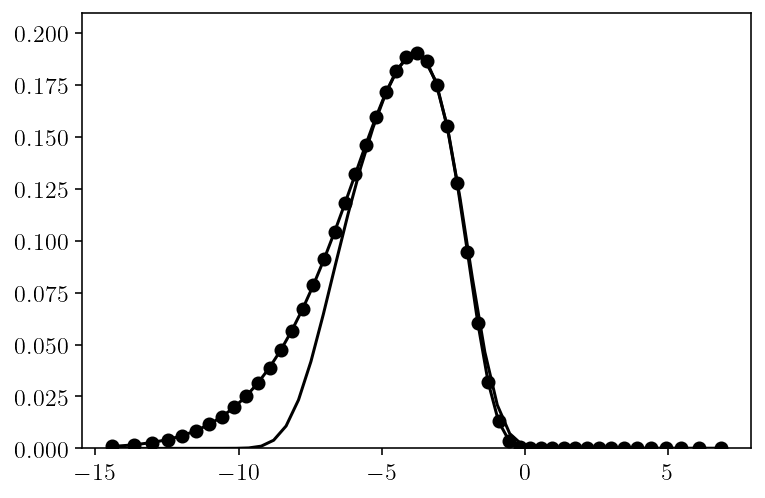

In [11]:
log_density_at_joint_mode = np.log(arm_post[0, (arm_post.shape[1] - 1) // 2, 0, sig_idx])
def taylor(x, mu, sd, derivs):
    xh = (x - mu)
    logp = (
        log_density_at_joint_mode
        + xh * derivs[1]
        + (1 / 2) * xh ** 2 * derivs[2]
        + (1 / 6) * xh ** 3 * derivs[3]
        + (1 / 24) * xh ** 4 * derivs[4]
    )
    return np.exp(logp)


expansion_xs = cx[:, 0, sig_idx]
expansion_mu = x_max[0, sig_idx, arm_idx]
expansion_sd = std_dev[sig_idx, arm_idx]

Asd = std_dev[sig_idx, arm_idx]
Amu = x_max[0, sig_idx, arm_idx]
arm_xs = arm_cx[arm_idx, :, 0, sig_idx]
arm_p = arm_post[arm_idx, :, 0, sig_idx]
xs = np.linspace(np.min(arm_xs), np.max(arm_xs), 50)
expansion_pdf = taylor(xs, expansion_mu, expansion_sd, ds[:, 0, sig_idx])
plt.plot(arm_xs, arm_p, 'k-o')
plt.plot(xs, expansion_pdf, 'k-')
plt.ylim([np.min(arm_p), np.max(arm_p) * 1.1])
plt.show()

## Set up the tools for Skew-Normal distributions.

In the previous skew-normal notebook, we calculated the $\gamma^{(i)}$ variables explicitly using the formulas from the Rue paper. Here, we compute them just using automatic differentiation!

In [12]:
gamma_i = ds[:, 0, sig_idx] 
gamma0, gamma1, gamma2, gamma3, gamma4 = gamma_i
gamma_i

array([-2.77614884e+01, -9.71626263e-03, -2.54321533e-01, -1.86684145e-01, -1.79467378e-01])

Then we'll set up a bunch of functions for working productively with **skew-normal distributions**. Things like:
- density
- mode
- mean
- variance

and so on...

In [13]:
def log_normal_pdf(xt):
    return jax.scipy.stats.norm.logpdf(xt)


def log_normal_cdf(xt):
    return jax.scipy.stats.norm.logcdf(xt)


def sn_log_pdf(z, xi, w, a):
    xt = (z - xi) / w
    return jnp.log(2) - jnp.log(w) + log_normal_pdf(xt) + log_normal_cdf(a * xt)


def sn_pdf(xs, xi, w, a):
    return scipy.stats.skewnorm(a, loc=xi, scale=w).pdf(xs)


def sn_mode_f(xi, w, a):
    delta = a / jnp.sqrt(1 + a**2)
    mu_z = jnp.sqrt(2 / jnp.pi) * delta
    sigma_z = jnp.sqrt(1 - mu_z**2)
    sn_skew = (
        (4 - jnp.pi)
        * 0.5
        * (delta * jnp.sqrt(2 / jnp.pi)) ** 3
        / (1 - 2 * delta**2 / jnp.pi) ** 1.5
    )
    m0 = (
        mu_z
        - sn_skew * sigma_z / 2
        - jnp.sign(a) / 2 * jnp.exp(-2 * jnp.pi / jnp.abs(a))
    )
    return xi + w * m0


def sn_rue_mode_f(xi, w, a):
    return (
        (a / w) * (np.sqrt(2 * np.pi) + 2 * xi * (a / w)) / (np.pi + 2 * (a / w) ** 2)
    )


def sn_mean_f(xi, w, a):
    delta = a / jnp.sqrt(1 + a**2)
    return xi + w * delta * np.sqrt(2 / np.pi)


def sn_var_f(xi, w, a):
    delta = a / jnp.sqrt(1 + a**2)
    return w**2 * (1 - 2 * delta**2 / jnp.pi)


def make_sn_deriv(order):
    f = sn_log_pdf
    for i in range(order):
        f = jax.grad(f)
    return jax.jit(f)


sn_ds = [make_sn_deriv(i) for i in range(5)]

In [14]:
def report(soln, jax_jit=False):
    out = dict(
        xi=soln[0],
        omega=soln[1],
        a=soln[2],
        rue_mode=sn_rue_mode_f(*soln),
        mode=sn_mode_f(*soln),
        mean=sn_mean_f(*soln),
        var=sn_var_f(*soln),
    )

    if not jax_jit:
        mean2, var2, skew, kurt = scipy.stats.skewnorm(
            soln[2], loc=soln[0], scale=soln[1]
        ).stats(moments="mvsk")
        out.update(
            dict(
                skew=skew,
                kurt=kurt,
            )
        )
        np.testing.assert_allclose(mean2, out['mean'])
        np.testing.assert_allclose(var2, out['var'])

    # what points of interest do we have?
    # - the mean
    # - the wikipedia mode appx called out['mode'] here
    # - the rue 2013 mode appx called out['rue_mode'] here
    # - the joint mode!
    for i in range(0, len(sn_ds)):
        out[f"d{i}"] = sn_ds[i](out["mode"], *soln)

    for i in range(0, len(sn_ds)):
        out[f"d{i}_rue"] = sn_ds[i](out["rue_mode"], *soln)

    # the joint mode is at x = 0 for the skew-normal density
    for i in range(0, len(sn_ds)):
        out[f"d{i}_joint"] = sn_ds[i](0.0, *soln)
    return out


In [15]:
def compare_solns(solns_and_names, include_gaussian=False, include_taylor=False):
    plt.figure(figsize=(10, 5))
    plt.plot(
        arm_xs, arm_post[armi_idx, :, 0, sig_idx], "k--o", label="Laplace approximation"
    )
    xs = np.linspace(np.min(arm_xs), np.max(arm_xs), 50)

    if include_gaussian:
        plt.plot(
            xs,
            scipy.stats.norm.pdf(xs, loc=Amu, scale=Asd),
            "m--",
            label="Gaussian approximation",
        )
    if include_taylor:
        plt.plot(xs, expansion_pdf, "r--", label="Taylor expansion")

    for s, n in solns_and_names:
        plt.plot(xs, sn_pdf(xs - expansion_mu, *s), linestyle='solid', label=n)

    plt.xlabel(r'$\theta_0$')
    plt.ylabel(r'$p(\theta_0 | \sigma^2, y)$')
    plt.legend()

The Rue SLA proceeds more or less like:
- calculate a taylor series expansion of the full Laplace approximation at the mode identified by optimization
- fit a skew-normal to this expansion by:
    1. assume that the first order coefficient in that expansion is the mean
    2. assume that the second order coefficient in that expansion is the variance
    3. approximate the mode of the skew-normal
    4. assume that the the third derivative at the mode of this skew-normal is equal to the third coefficient in the expansion

So, for the Rue skew-normal fit:
- the mean should be equal to $\gamma^{(1)}$.
- the variance should be to $-1 / \gamma^{(2)}$.
- the third derivative at the Rue mode (`d3_rue` above) should be approximately equal to $\gamma^{(3)}$.

In [16]:
def rue_skew_normal_fit(gamma1, gamma2, gamma3):
    C = (4 - np.pi) * np.sqrt(2) / (np.pi ** 1.5)
    R = np.cbrt(gamma3 / C)
    w_a = R ** 2 * (1 - 2 / np.pi)
    w_b = 1 + (1.0 / gamma2) * R ** 2
    w_c = (1.0 / gamma2)
    if w_a == 0:
        w2 = -w_c / w_b
    else:
        w2_1 = (-w_b + np.sqrt(w_b ** 2 - 4 * w_a * w_c)) / (2 * w_a)
        w2_2 = (-w_b - np.sqrt(w_b ** 2 - 4 * w_a * w_c)) / (2 * w_a)
    w2 = w2_1
    w = np.sqrt(w2) * (-np.sign(gamma3))
    a = R * w
    delta = a / np.sqrt(1 + a ** 2)
    xi = gamma1 - w * delta * np.sqrt(2 / np.pi)
    return np.array([xi, w, a])

rue_soln = rue_skew_normal_fit(gamma1, gamma2, gamma3)
pprint(report(rue_soln))
gamma1, -1.0 / gamma2, gamma3

{'a': -2.8628764221802645,
 'd0': DeviceArray(-1.53304515, dtype=float64),
 'd0_joint': DeviceArray(-1.62661941, dtype=float64),
 'd0_rue': DeviceArray(-1.56656439, dtype=float64),
 'd1': DeviceArray(0.00396376, dtype=float64),
 'd1_joint': DeviceArray(0.21039222, dtype=float64, weak_type=True),
 'd1_rue': DeviceArray(0.13630296, dtype=float64),
 'd2': DeviceArray(-0.34205575, dtype=float64),
 'd2_joint': DeviceArray(-0.18977228, dtype=float64, weak_type=True),
 'd2_rue': DeviceArray(-0.24480141, dtype=float64),
 'd3': DeviceArray(-0.23753121, dtype=float64),
 'd3_joint': DeviceArray(-0.13412011, dtype=float64, weak_type=True),
 'd3_rue': DeviceArray(-0.18586621, dtype=float64),
 'd4': DeviceArray(-0.07737743, dtype=float64),
 'd4_joint': DeviceArray(-0.15266338, dtype=float64, weak_type=True),
 'd4_rue': DeviceArray(-0.14247261, dtype=float64),
 'kurt': array(0.48713488),
 'mean': DeviceArray(-0.00971626, dtype=float64),
 'mode': DeviceArray(0.79737909, dtype=float64),
 'omega': 3.014

(-0.009716262625455222, 3.9320303995390002, -0.18668414543379036)

Now, we want to construct an improved skew-normal approximation. We have various constraints:
- We don't know the true mode of the full laplace approximation that we're fitting (or, for that matter, the true marginal density!). What we do know is the mode of the joint density. 
- Do we know the value of the laplace approximation at the joint mode? The problem is that computing the value of the density at the joint mode requires computing the entire laplace density. Otherwise, we don't have a sense of the correct normalization factor.
- We do know derivatives at the mode of the joint density. 
- We do have a much better approximation for the mode available than the one used by Rue.

We actually *could* calculate the mode of the laplace appx, but that would require calculating the laplace appx several times at which point we might as well just do full laplace and spread those points out to cover more of the distribution. 
- but maybe computing four points of the laplace appx and then fitting a skew-normal to those four points would be better? Yeah, that could be good, but the downside is that the fitting process would not be possible to do analytically and we'd have to resort to variational inference. That could still be much faster than doing the full laplace appx though. It's more of an intermediate option. 
- developing intermediate options like this is something I'd really like to do because it gives us fine-grained control over the quality of the approximation.

To start with, we'll define an objective function for our fit and then run a simple optimization algorithm to find the best fitting skew-normal parameters. Let's do this first for the objective corresponding to the Rue solution.


This is actually going to give a slightly different output than the actual Rue solution because our third derivatives here include terms from both the numerator and denominator in Rue equations (18) through (21). But, the resulting difference is absolutely tiny! In a sense, this validates Rue's choice to leave terms beyond the first order term in the denominator in expression (20).

In [17]:
def grad_desc(lr, x0, f, n_iter=1000):
    soln = x0
    f_jit = jax.jit(f)
    grad_f_jit = jax.jit(jax.grad(f))
    for i in range(n_iter):
        obj = f_jit(soln)
        grad = grad_f_jit(soln)
        if i % 100 == 0 or i == n_iter - 1:
            print(soln, obj, grad)
        soln -= grad * lr
    return soln

def obj_rue(args):
    r = report(args, jax_jit=True)
    return (r['mean'] - gamma1) ** 2 + (r['var'] - (-1.0 / gamma2)) ** 2 + (r['d3_rue'] - gamma3) ** 2

# We're going to set x0 for the optimizer to be rue_soln. This seems like a decent starting point!
opt = lambda f: scipy.optimize.minimize(f, rue_soln)
rue_opt_soln = opt(obj_rue)['x']
rue_opt_soln, rue_soln

(array([ 2.26274378,  3.0159745 , -2.87058785]),
 array([ 2.26121014,  3.01481959, -2.86287642]))

The Rue fit doesn't look good at all!

The problem seems to be that the Rue approximation of the mode is very different from the true mode. Unfortunately, it's *ALSO* very different from the mode of the fitted skew-normal!

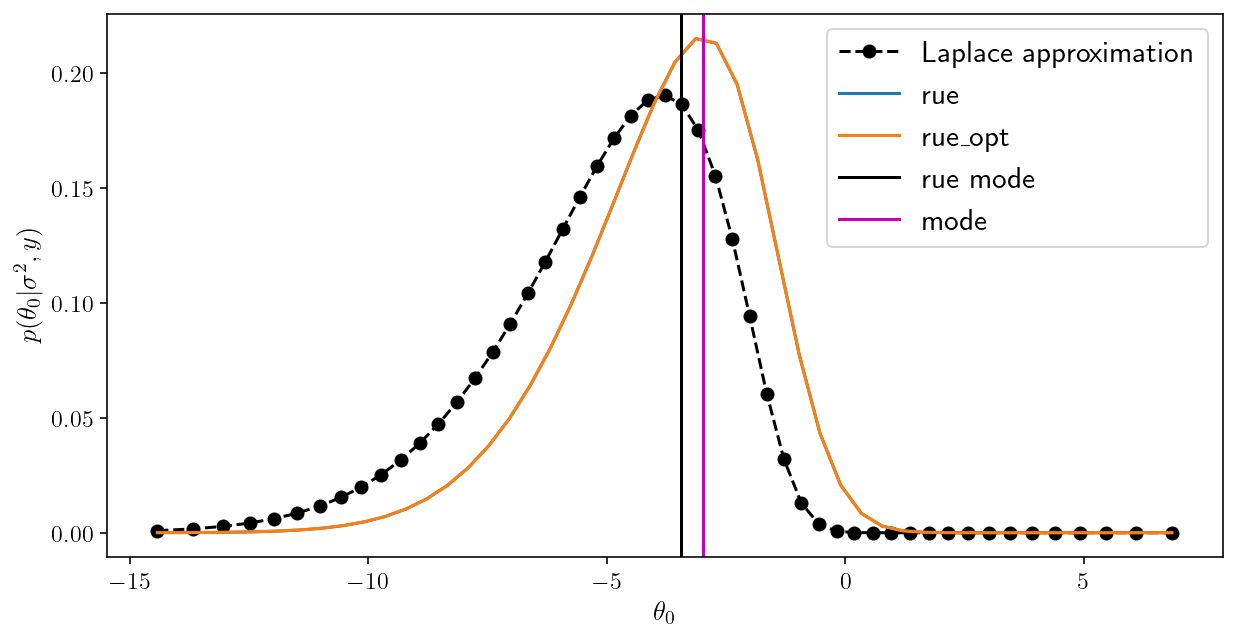

In [18]:
compare_solns([(rue_soln, "rue"), (rue_opt_soln, "rue_opt")])
r = report(rue_soln)
plt.axvline(r['rue_mode'] + expansion_mu, color='k', label='rue mode')
plt.axvline(r['mode'] + expansion_mu, color='m', label='mode')
plt.legend()
plt.show()

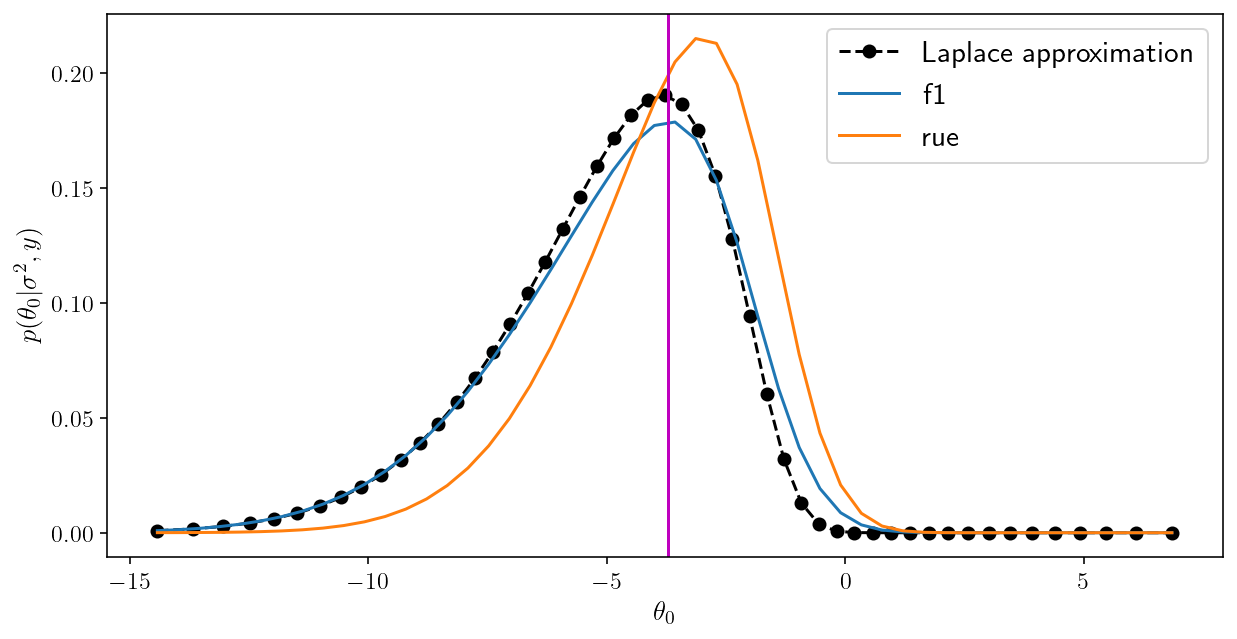

In [19]:
## SOLUTION 1: We get a big improvement by fitting derivatives at the mode instead of mean/variance.
def obj_f1(args):
    r = report(args, jax_jit=True)
    return (r['d1_rue'] - gamma1) ** 2 + (r['d2_rue'] - gamma2) ** 2 + (r['d3_rue'] - gamma3) ** 2
soln1 = opt(obj_f1)['x']
compare_solns([(soln1, "f1"), (rue_soln, "rue")])
r = report(soln1)
plt.axvline(r['mode'] + expansion_mu, color='m', label='mode')
plt.show()
    # return (r['d1'] - gamma1) ** 2 + (r['d2'] - gamma2) ** 2 + (r['d3'] - gamma3) ** 2

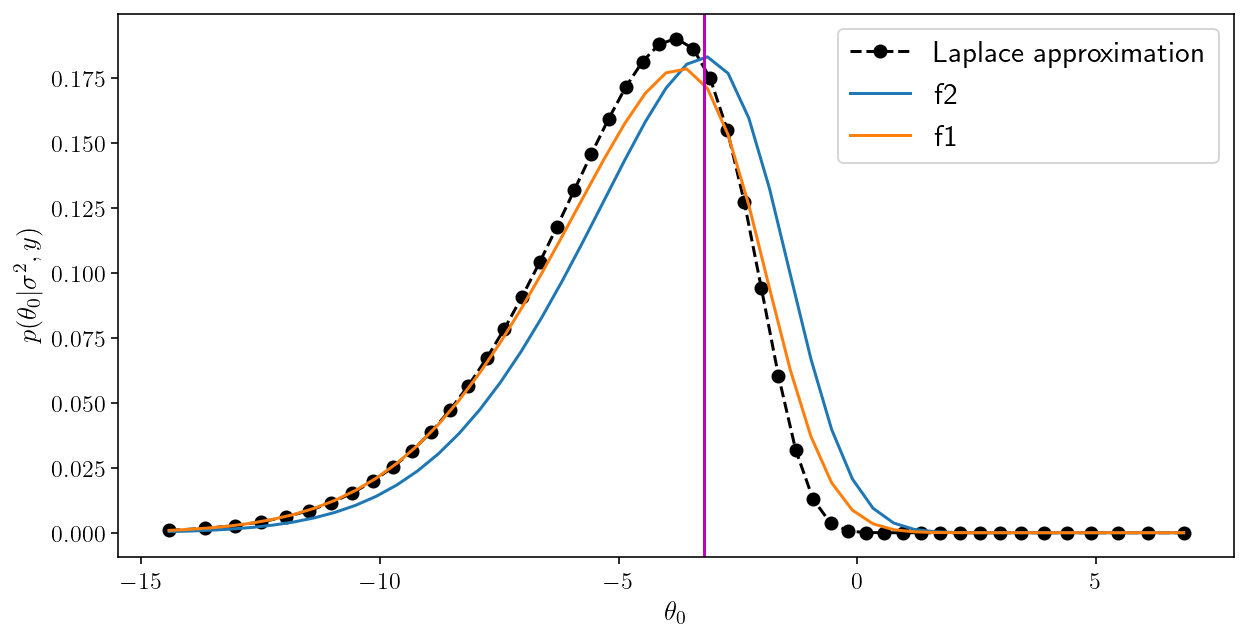

In [20]:
## SOLUTION 2: doing the same thing but at the true mode instead of the rue
## mode actually does worse. this is suspicious.
def obj_f2(args):
    r = report(args, jax_jit=True)
    return (r['d1'] - gamma1) ** 2 + (r['d2'] - gamma2) ** 2 + (r['d3'] - gamma3) ** 2
soln2 = opt(obj_f2)['x']
compare_solns([(soln2, "f2"), (soln1, "f1")])
r = report(soln2)
plt.axvline(r['mode'] + expansion_mu, color='m', label='mode')
plt.show()

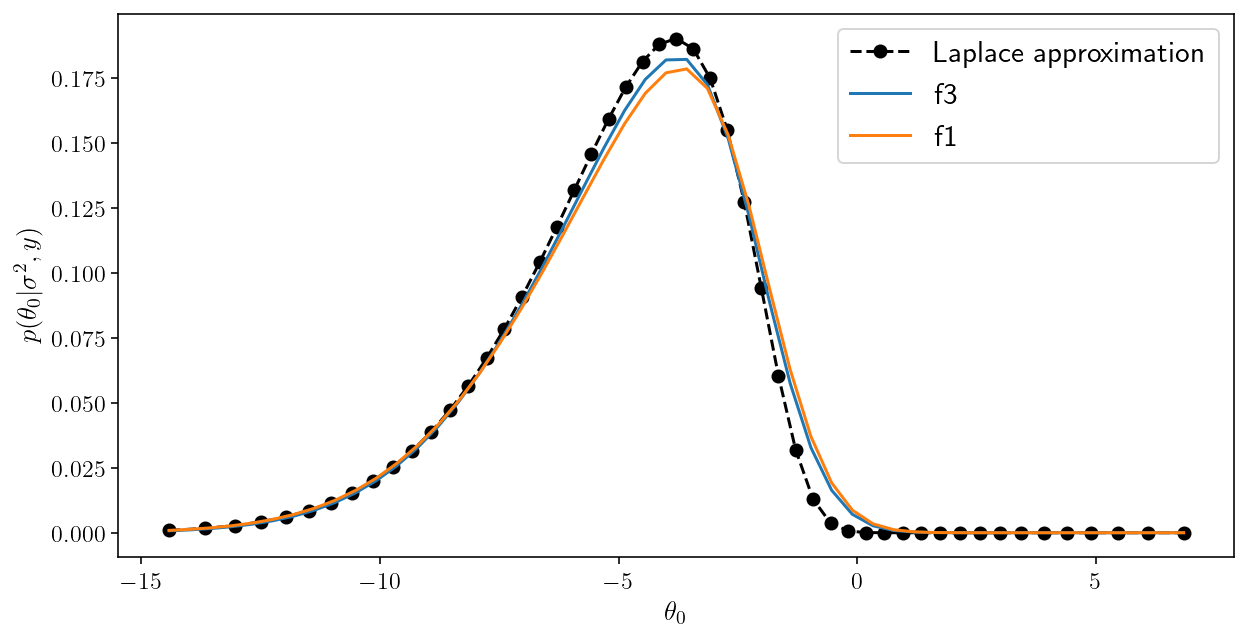

In [21]:
## SOLUTION 3: pushing the mode towards the joint mode works best! 
# Is there a good justification for why this is a good idea? 
# maybe... we should generally expect that the marginal modes don't differ very
# much from the joint mode. it's sort of a regularization argument.
# an alternative would be to identify the *true* mode. or maybe do one
# optimization step in that direction. 
# NOTE: Is there a class of methods here that are indexed by:
# 1. the number of optimization steps used to identify the mode of the skew-normal.
# 2. the order of the distribution? Is there an extended extended skew-normal
#    that incorporates a fifth term??
# I think that using more derivatives at a single point will rapidly become
# worse than using multiple points: 
# At every point that we compute the laplace approximation, we know:
# - the value of the density at that point (before normalization)
# - the first few derivatives at that point?
# So, it would be possible to construct an interpolation that took advantage of
# those derivatives. But, how do we smoothly transition between the skew-normal
# 1-point approximation and the n-point approximation? That's where the Rue
# trick where he multiplies by a spline function comes in. You use the
# skew-normal as the baseline density and then construct a spline to multiply
# the density by. 
def obj_f3(args):
    r = report(args, jax_jit=True)
    return (r['mode']) ** 2 + (r['d2'] - gamma2) ** 2 + (r['d3'] - gamma3) ** 2
soln3 = opt(obj_f3)['x']
compare_solns([(soln3, "f3"), (soln1, "f1")])
plt.show()

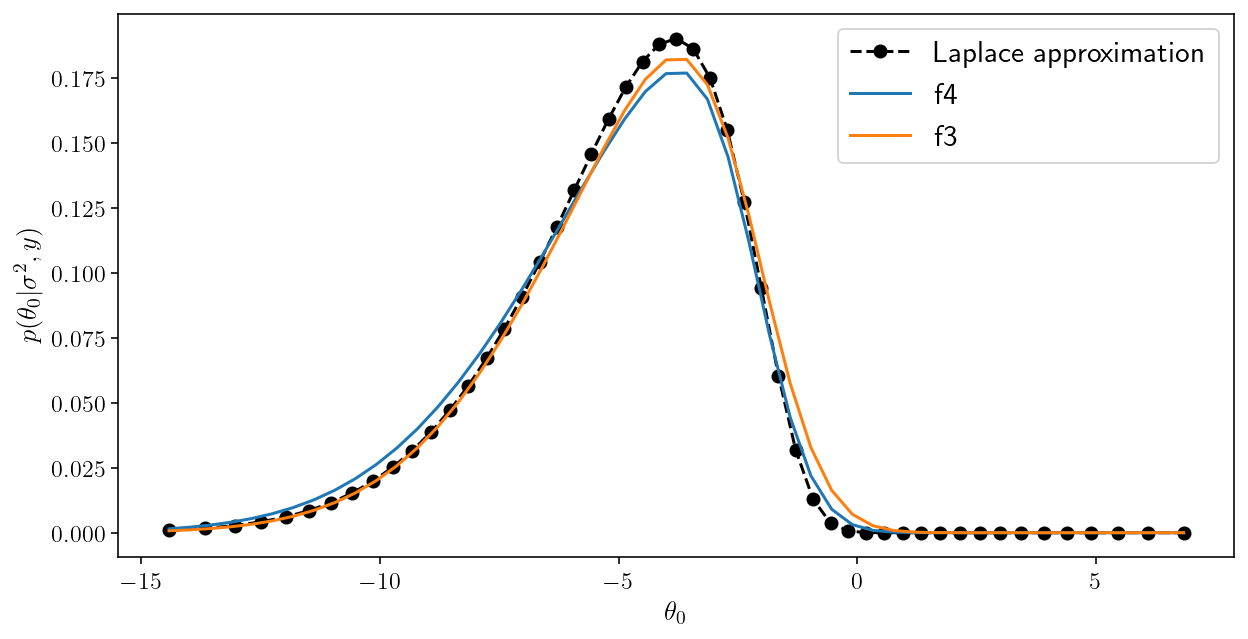

In [22]:
## SOLUTION 4: fitting second and fourth derivatives is also pretty decent
def obj_f4(args):
    r = report(args, jax_jit=True)
    return (r['mode']) ** 2 + (r['d4'] - gamma4) ** 2 + (r['d2'] - gamma2) ** 2
soln4 = opt(obj_f4)['x']
compare_solns([(soln4, "f4"), (soln3, "f3")])
plt.show()

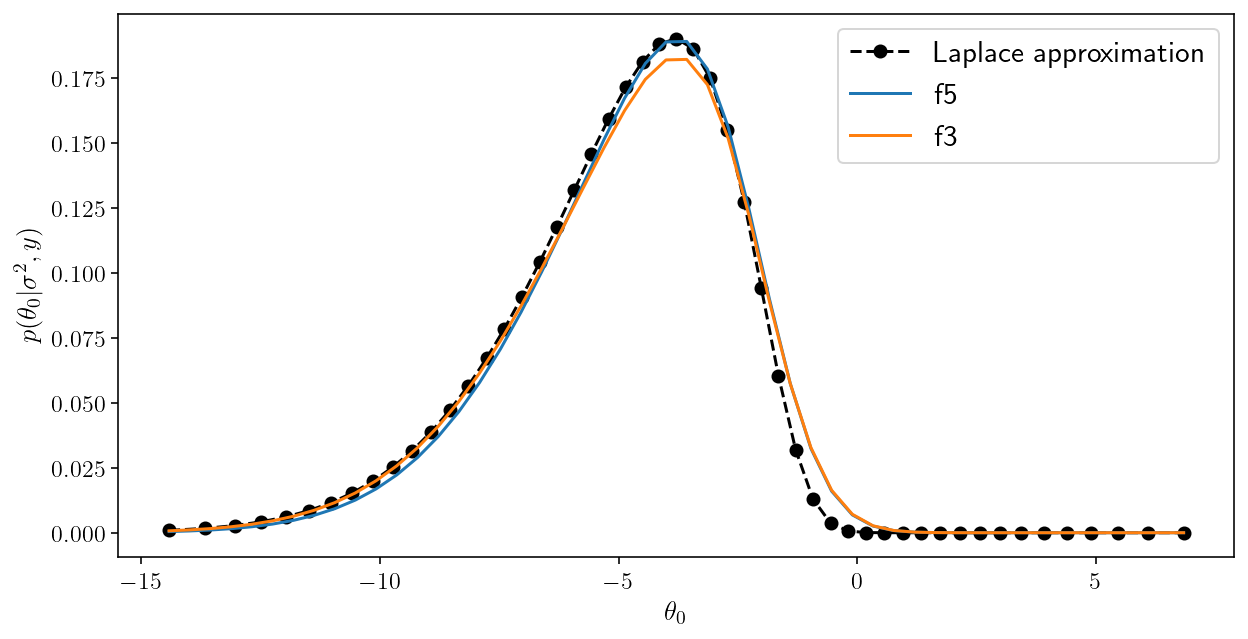

In [23]:
## SOLUTION 5: what if we fit the laplace density at the joint mode??
# this seems to work well, especially at the mode! but it's problematic because
# we don't actually have access to the laplace density at the joint mode
# without computing the full laplace approximation - the normalization factor
# is not yet available.
def obj_f5(args):
    r = report(args, jax_jit=True)
    return (r['mode']) ** 2 + (r['d0'] - log_density_at_joint_mode) ** 2 + (r['d3'] - gamma3) ** 2
soln5 = opt(obj_f5)['x']
compare_solns([(soln5, "f5"), (soln3, "f3")])
plt.show()

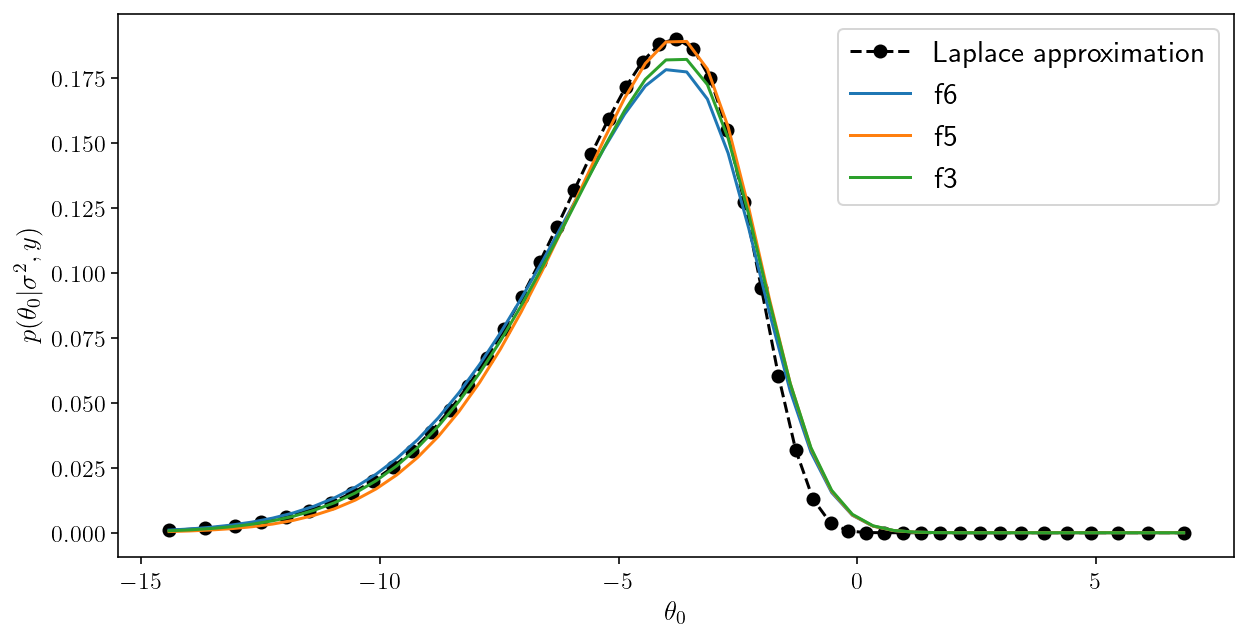

In [24]:
## SOLUTION 6: what if we fit the first three derivatives at the joint mode?
# In some sense, this is the most justifiable approximation since it's using
# only the information that we have and making no extra assumptions.
# the approximation isn't quite as good as when we assume the joint mode is
# equal to the marginal mode, but that might just be a quirk of this particular
# problem.
def obj_f6(args):
    r = report(args, jax_jit=True)
    return (r['d1_joint'] - gamma1) ** 2 + (r['d2_joint'] - gamma2) ** 2 + (r['d3_joint'] - gamma3) ** 2
soln6_full = opt(obj_f6)
soln6 = soln6_full['x']
compare_solns([(soln6, "f6"), (soln5, "f5"), (soln3, "f3")])
plt.show()

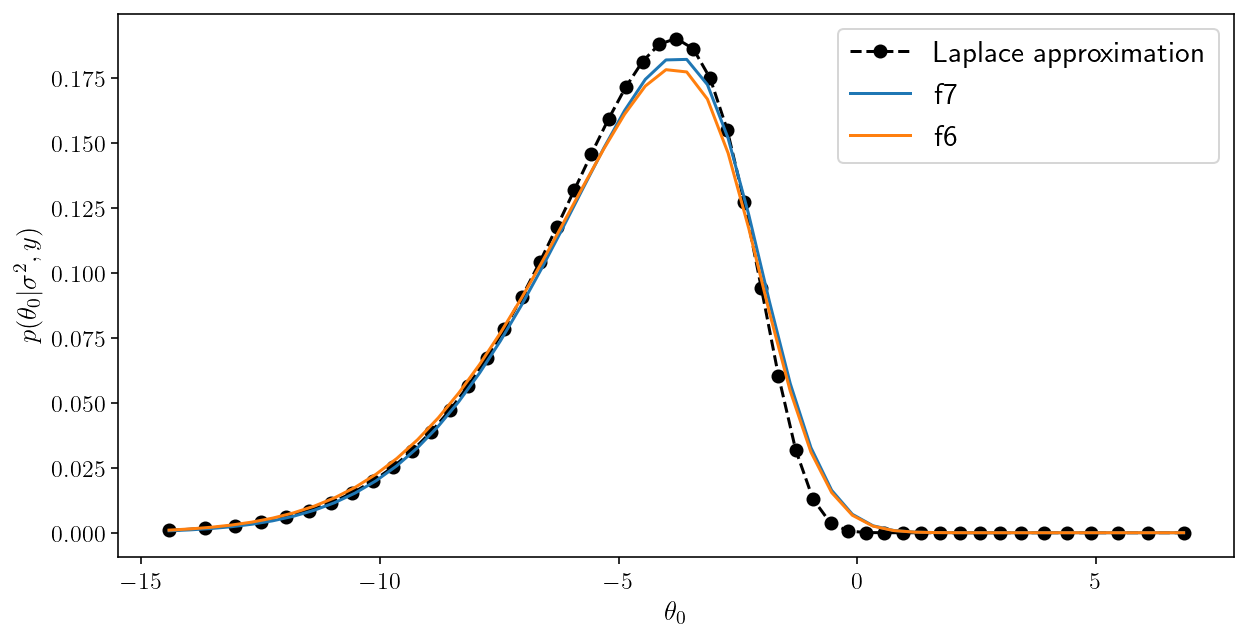

In [25]:
## SOLUTION 7: still consider derivatives at the joint mode, but also shrink the mode
def obj_f7(args):
    r = report(args, jax_jit=True)
    return (r['mode'] - 0) ** 2 + (r['d2_joint'] - gamma2) ** 2 + (r['d3_joint'] - gamma3) ** 2
soln7_full = opt(obj_f7)
soln7 = soln7_full['x']
compare_solns([(soln7, "f7"), (soln6, "f6")])
plt.show()

In [26]:
report(soln6)['d1_joint']

DeviceArray(-0.00972311, dtype=float64, weak_type=True)

In [27]:
soln6_full

      fun: 1.5230458221787993e-09
 hess_inv: array([[   5.33554003,   10.92364369,  -11.31642077],
       [  10.92364369,  125.55815113, -130.38404714],
       [ -11.31642077, -130.38404714,  156.71918458]])
      jac: array([-8.14028636e-06, -7.27905172e-06, -9.36734297e-06])
  message: 'Optimization terminated successfully.'
     nfev: 76
      nit: 17
     njev: 19
   status: 0
  success: True
        x: array([ 1.66639293,  3.75772306, -3.33025394])

In [28]:
soln6.tolist()

[1.6663929335692391, 3.757723064525265, -3.3302539408014247]

In [29]:
gamma1, gamma2, gamma3

(-0.009716262625455222, -0.25432153325092355, -0.18668414543379036)

In [33]:
def objective(args):
    return (
        (sn_ds[1](0.0, *args) - gamma1) ** 2
        + (sn_ds[2](0.0, *args) - gamma2) ** 2
        + (sn_ds[3](0.0, *args) - gamma3) ** 2
    )
obj_jit = jax.jit(jax.vmap(objective))
grad_jit = jax.jit(jax.vmap(jax.grad(objective)))
hessian_jit = jax.jit(jax.vmap(jax.hessian(objective)))
soln6_tiled = np.tile(soln6, (int(1e6), 1))

In [31]:
obj_jit(np.array([soln6]))

DeviceArray([1.52304582e-09], dtype=float64)

In [32]:
for i in range(5):
    print(sn_ds[i](0.0, *soln6))

-1.7203531943307024
-0.009723111857446554
-0.2543193826680293
-0.18672250568452628
-0.0711828601103993


In [35]:
%%timeit
_ = hessian_jit(soln6_tiled)

133 ms ± 2.26 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [53]:
avs = np.linspace(0, 5, 31)
wvs = np.linspace(0.5, 10, 32)
ag, wg = np.meshgrid(avs, wvs, indexing='ij')

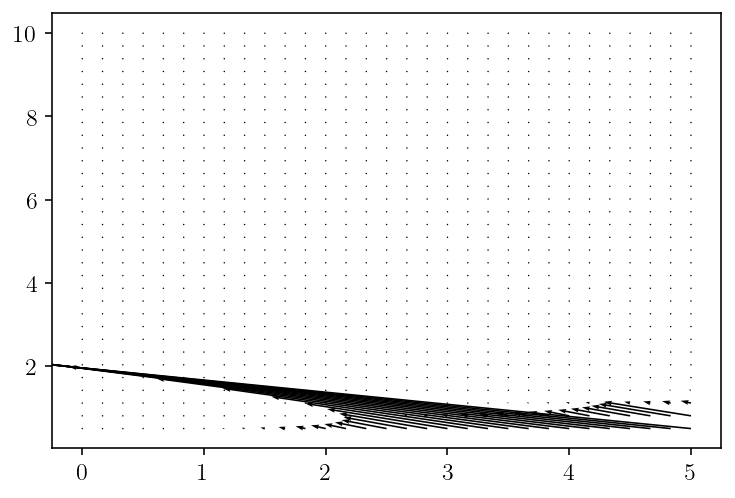

In [54]:
pts = np.stack((np.zeros_like(wg.ravel()), wg.ravel(), ag.ravel()), axis=-1)
grad_grid = grad_jit(pts)
plt.quiver(ag, wg, grad_grid[:, 1].reshape(ag.shape), grad_grid[:, 2].reshape(ag.shape))
plt.show()

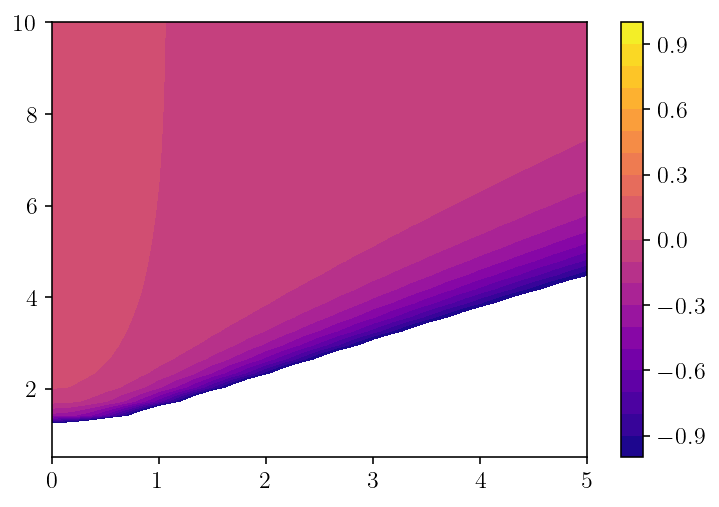

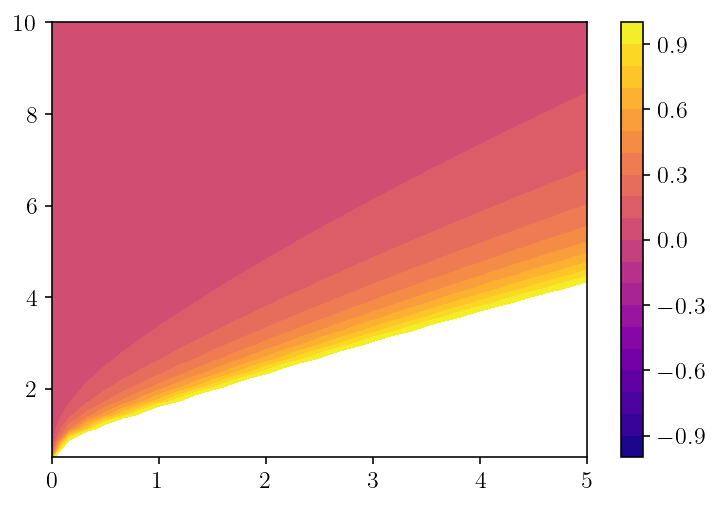

In [59]:
for i in range(1, 3):
    plt.contourf(ag, wg, grad_grid[:, i].reshape(ag.shape), levels=np.linspace(-1, 1, 21))
    plt.colorbar()
    plt.show()

<img src="2022-08-15-11-19-50.png" width="400px"/>

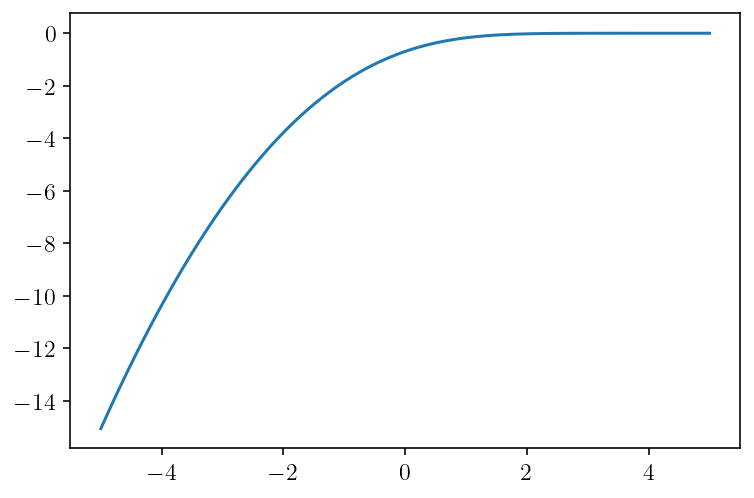

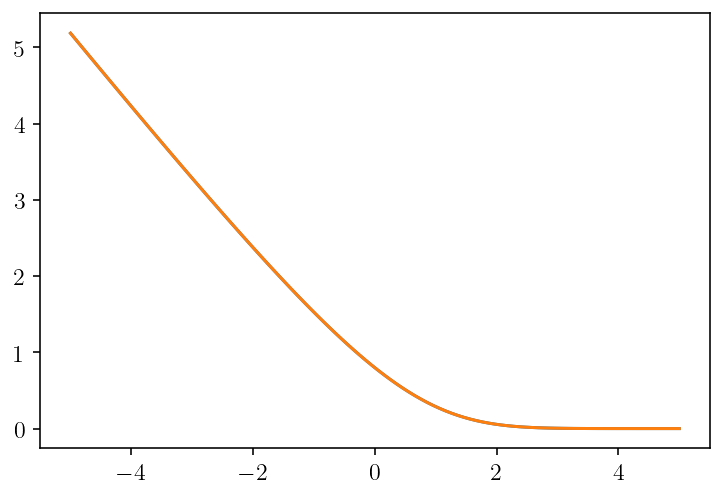

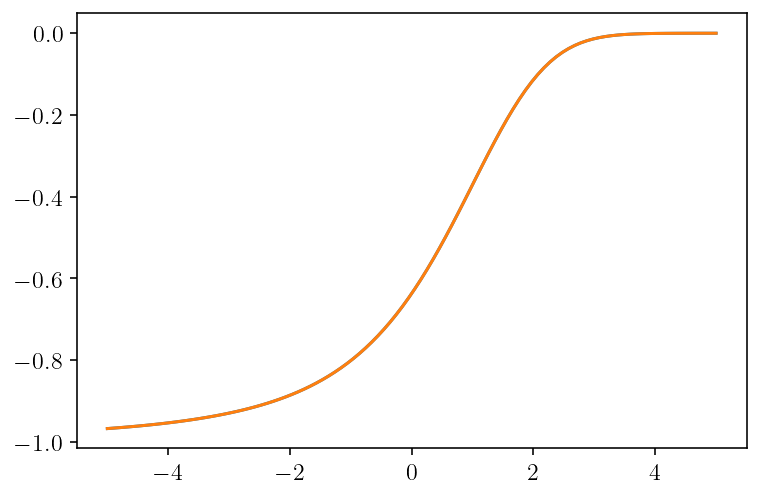

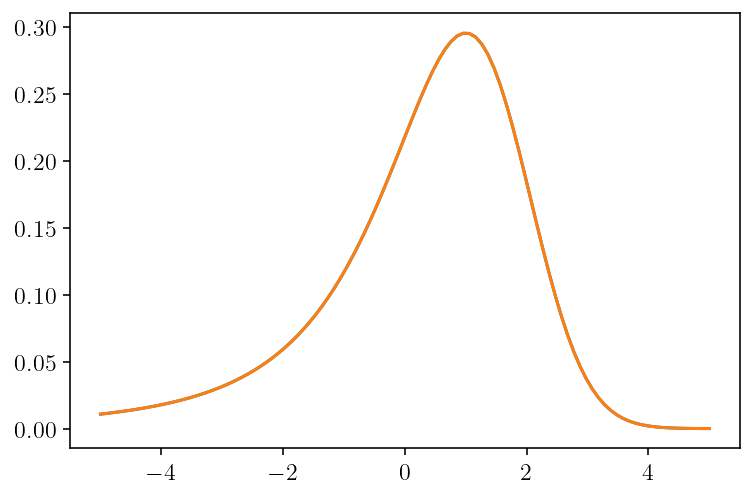

In [31]:
xs = np.linspace(-5, 5, 100)
plt.plot(xs, jax.scipy.special.log_ndtr(xs))
plt.show()
plt.plot(xs, jax.vmap(jax.grad(jax.scipy.special.log_ndtr))(xs))
psi1 = scipy.stats.norm.pdf(xs) / scipy.stats.norm.cdf(xs)
psi2 = -psi1 ** 2 - xs * psi1
psi3 = 2 * psi1 ** 3 + 3 * xs * psi1 ** 2 + xs ** 2 * psi1 - psi1
plt.plot(xs, psi1)
plt.show()
plt.plot(xs, jax.vmap(jax.grad(jax.grad(jax.scipy.special.log_ndtr)))(xs))
plt.plot(xs, psi2)
plt.show()
plt.plot(xs, jax.vmap(jax.grad(jax.grad(jax.grad(jax.scipy.special.log_ndtr))))(xs))
plt.plot(xs, psi3)
plt.show()